In [192]:
from transformers import (
    SamProcessor,
    SamModel,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = "tight"
from PIL import Image
from torchvision.io import read_image

In [193]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image), "jet", interpolation="none", alpha=0.8)
        axes[0].show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()


def store_image_with_mask(image, masks, scores, path):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()
    plt.plot()

    mask = masks[0]
    plt.figure()
    plt.imshow(image)
    mask = mask.cpu().detach()
    plt.imshow(mask, alpha=0.6, cmap="jet")
    plt.axis("off")
    plt.savefig(f"{path}.png", bbox_inches="tight", transparent="True", pad_inches=0)

In [194]:
from datasets import load_dataset

dataset = load_dataset("nielsr/breast-cancer", "default", split="train")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [195]:
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")

KeyboardInterrupt: 

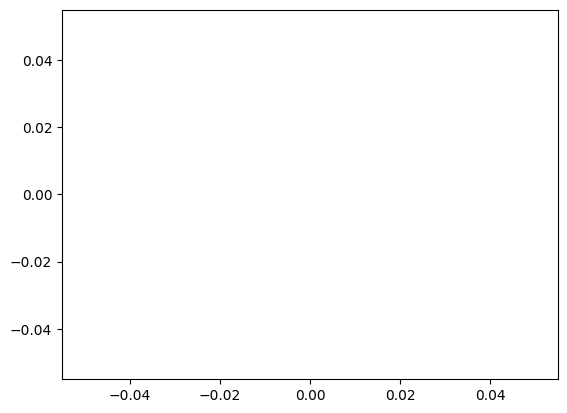

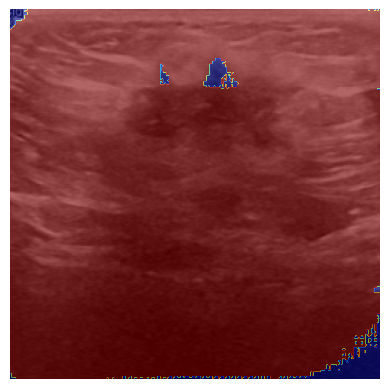

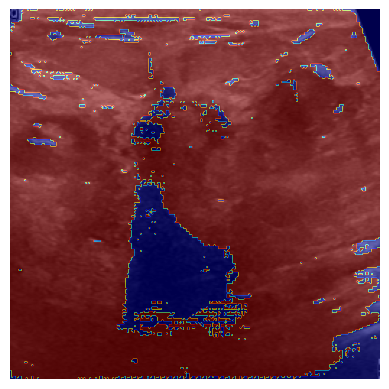

In [196]:
output = None
for i in range(50):
    image = dataset[i]["image"]
    inputs = processor(image, return_tensors="pt").to(device)
    model = SamModel.from_pretrained("ayoubkirouane/Breast-Cancer_SAM_v1").to(device)
    with torch.no_grad():
        output = model(**inputs)
    masks = processor.image_processor.post_process_masks(
        output.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu(),
    )
    store_image_with_mask(image, masks[0], output.iou_scores, f"masked/mask{i}")
    

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])